In [2]:
import os
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
# display the figures in the Notebook
%matplotlib inline

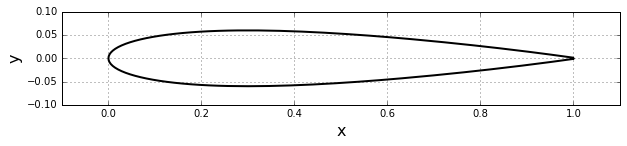

In [3]:
# read of the geometry from a data file
naca_filepath = os.path.join('naca0012.dat')
with open (naca_filepath, 'r') as file_name:
    x, y = numpy.loadtxt(file_name, dtype=float, delimiter='\t', unpack=True)

# plot the geometry
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

In [4]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is on the lower or upper surface of the geometry.
        Initializes the source-sheet strength, tangential velocity,
        and pressure coefficient to zero.
        
        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

In [5]:
def define_panels(x, y, N=40):
    """ 
    Discretizes the geometry into panels using the cosine
    
    x: x-coordinate of the points defining the geometry 
    y: y-coordinate of the points defining the geometry 
    N: number of panels 
    
    panels: the discretization of the geometry into panels 
    """
    
    R = (x.max()-x.min())/2           #radius of circle
    x_center = (x.max()+x.min())/2            #x coordinate of the center
    x_circle = x_center + R*numpy.cos(numpy.linspace(0, 2*math.pi, N+1))  #x coordinates of the circle points
    
    x_ends = numpy.copy(x_circle)     #projection of the x coord on the surface
    y_ends = numpy.empty_like(x_ends)   #initialization of y coord numpy array
    
    x, y = numpy.append(x, x[0]), numpy.append(y, y[0])   #extend arrays using numpy.append
    
    #computes the y-coordinate of end points 
    
    I = 0
    for i in range(N):
        while I < len(x)-1:
            if (x[I] <= x_ends[i] <= x[I+1]) or (x[I+1] <= x_ends[i] <= x[I]):
                break 
            else:
                I += 1
                
        a = (y[I+1] - y[I]) / (x[I+1] - x[I])
        b = y[I+1] - a*x[I+1]
        y_ends[i] = a*x_ends[i] + b
        
    y_ends[N] = y_ends[0]
    
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
        
    return panels

(-0.1, 0.1)

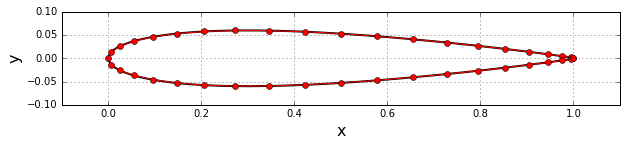

In [6]:
N = 40 
panels = define_panels(x, y, N)

width=10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa), 
           numpy.append([panel.ya for panel in panels], panels[0].ya), 
           linestyle='-', linewidth=1, marker='o', markersize=6, color='r')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1)

In [7]:
class Freestream:
    """
    Freestream conditions
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle with the x axis 
        
        u_inf: freestream speed 
        alpha: angle of attack in degrees"""
        
        self.u_inf = u_inf
        self.alpha = alpha*math.pi/180

In [8]:
u_inf = 1.0
alpha = 0.0 
freestream = Freestream(u_inf, alpha)

In [9]:
def integral(x, y, panel, dxdz, dydz):
 
    def integrand(s):
        return ( ((x - (panel.xa - math.sin(panel.beta)*s))*dxdz
                  +(y - (panel.ya + math.cos(panel.beta)*s))*dydz)
                / ((x - (panel.xa - math.sin(panel.beta)*s))**2
                   +(y - (panel.ya + math.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [10]:
def build_matrix(panels):
    """Builds the source matrix 
    panels: the source panels
    A: the source matrix, NxN matrix
    """
    N = len(panels)
    A = numpy.empty((N, N), dtype=float)
    numpy.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/math.pi*integral(p_i.xc, p_i.yc, p_j, math.cos(p_i.beta), math.sin(p_i.beta))
                
    return A 

def build_rhs(panels, freestream):
    """Builds the RHS of the linear system
    panels: the source panels
    freestream: freestream conditions 
    b: RHS of the linear system"""
    
    b = numpy.empty(len(panels), dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * math.cos(freestream.alpha - panel.beta)
        
    return b

In [11]:
A = build_matrix(panels)
b = build_rhs(panels, freestream)

In [12]:
#solve the linear system 
sigma = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

In [13]:
def get_tangential_velocity(panels, freestream):
    """Computes the tangential velocity on the surface of the panel 
    panels: the source panels
    freestream: the freestream conditions 
    """
    N = len(panels)
    A = numpy.empty((N,N), dtype=float)
    numpy.fill_diagonal(A, 0.0)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/math.pi*integral(p_i.xc, p_i.yc, p_j, -math.sin(p_i.beta), math.cos(p_i.beta))
                
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])
    
    sigma = numpy.array([panel.sigma for panel in panels])
    
    vt = numpy.dot(A, sigma) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [14]:
#compute the tangential velocity at the center-point of each panel 
get_tangential_velocity(panels, freestream)

In [15]:
def get_pressure_coefficient(panels, freestream):
    """Computes the surface pressure coefficients on the panels
    panels: source panels
    freestream: freestream conditions
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [16]:
get_pressure_coefficient(panels, freestream)

In [17]:
voverVsquared=numpy.array([0, 0.64, 1.01, 1.241, 1.378, 1.402, 1.411, 1.411, 1.399, 1.378, 1.35, 1.288, 1.228, 1.166, 1.109, 1.044, 0.956, 0.906, 0])
print(voverVsquared)

[ 0.     0.64   1.01   1.241  1.378  1.402  1.411  1.411  1.399  1.378
  1.35   1.288  1.228  1.166  1.109  1.044  0.956  0.906  0.   ]


In [18]:
xtheo=numpy.array([0, 0.5, 1.25, 2.5, 5.0, 7.5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 95, 100])
xtheo = xtheo/100
print(xtheo)

[ 0.      0.005   0.0125  0.025   0.05    0.075   0.1     0.15    0.2     0.25
  0.3     0.4     0.5     0.6     0.7     0.8     0.9     0.95    1.    ]


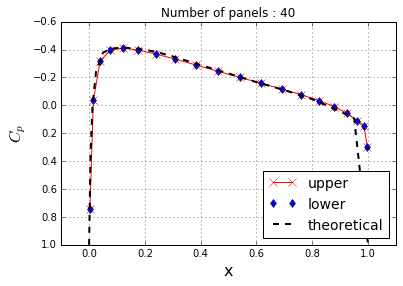

In [19]:
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper',
            color='r', linewidth=1, marker='x', markersize=8)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label='lower',
            color='b', linewidth=0, marker='d', markersize=6)
pyplot.plot(xtheo, 1-voverVsquared,
            label='theoretical',
            color='k', linestyle='--',linewidth=2)
pyplot.legend(loc='best', prop={'size':14})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(1.0, -0.6)
pyplot.title('Number of panels : %d' % N);

In [20]:
accuracy = sum([panel.sigma*panel.length for panel in panels])
print('--> sum of source/sink strengths: {}'.format(accuracy))

--> sum of source/sink strengths: 0.00461703117528311


In [21]:
def get_velocity_field(panels, freestream, X, Y):
    """Computes the velocity field on a given 2D mesh 
    panels: the source panels
    freestream: freestream conditions 
    X: x-coordinates of the mesh points
    Y: y-coordinates of the mesh points
    
    u: x-component of the velocity vector field 
    v: y-component of the velocity vector field 
    """
    
    #freestream contribution
    u = freestream.u_inf * math.cos(freestream.alpha) * numpy.ones_like(X, dtype=float)
    v = freestream.u_inf * math.sin(freestream.alpha) * numpy.ones_like(X, dtype=float)
    
    #add contribution from each source (superposition) 
    vec_integral = numpy.vectorize(integral)
    for panel in panels:
        u += panel.sigma / (2.0 * math.pi) * vec_integral(X, Y, panel, 1, 0)
        v += panel.sigma / (2.0 * math.pi) * vec_integral(X, Y, panel, 0, 1)
        
    return u, v

In [22]:
#define mesh grid 
nx, ny = 20, 20 #number of points in the x and y direction 
x_start, x_end = -1.0, 2.0
y_start, y_end = -0.3, 0.3
X, Y = numpy.meshgrid(numpy.linspace(x_start, x_end, nx), numpy.linspace(y_start, y_end, ny))

#compute velocity field on the mesh grid 
u, v = get_velocity_field(panels, freestream, X, Y)

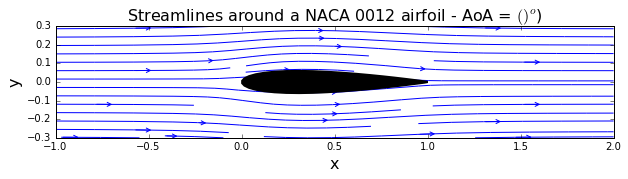

In [23]:
#plot velocity field 
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X,Y,u,v,
                 density=0.5, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels], 
           [panel.yc for panel in panels],
           color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Streamlines around a NACA 0012 airfoil - AoA = $()^o$)'.format(alpha), fontsize=16);

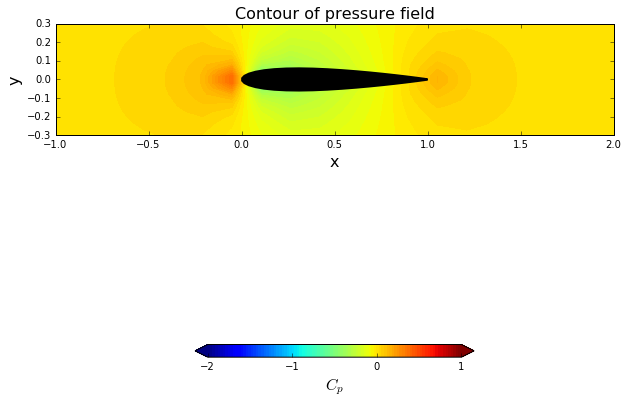

In [27]:
# compute the pressure field
cp = 1.0 - (u**2+v**2)/freestream.u_inf**2

# plot the pressure field
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
contf = pyplot.contourf(X, Y, cp,
                        levels=numpy.linspace(-2.0, 1.0, 100), extend='both')
cbar = pyplot.colorbar(contf,
                       orientation='horizontal',
                       shrink=0.5, pad = 0.1,
                       ticks=[-2.0, -1.0, 0.0, 1.0])
cbar.set_label('$C_p$', fontsize=16)
pyplot.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Contour of pressure field', fontsize=16);